# Combining multiple models
In this notebook I'll be experimenting further with combining multiple algos
This notebook is part of my Mercedes-Benz Kaggle efforts. Competion @: https://www.kaggle.com/c/mercedes-benz-greener-manufacturing Use of data subject to conditions mentioned in above link.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
#import re
import seaborn as sns
#import operator
import string
#from itertools import combinations
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import r2_score
from sklearn.kernel_ridge import KernelRidge
from sklearn import svm
from sklearn.ensemble import RandomForestRegressor
#from sklearn.decomposition import PCA
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process.kernels import Matern
#from IPython.display import clear_output

## 1. Load Data Sets

In [2]:
df_train = pd.read_csv('../data/train.csv').drop(['ID'],1).fillna(0)
df_train = df_train[df_train['y'] < 200] # drop one outlier data
df_test = pd.read_csv('../data/test.csv', index_col = 'ID').fillna(0)

## 2. Construct additional features and convert categorical featuresto continous

In [3]:
li_columnNames = [e for e in list(df_train.columns.values) if e not in {'y', 'X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X8'}]
list_value = list(string.lowercase) + list('a' + x for x in list(string.lowercase)) + ['ba', 'bb', 'bc']
i = 0
value_to_int = {}
for j in list_value:
    value_to_int[j] = i
    i += 1
df_train_eng = df_train.replace(value_to_int).copy()
df_test_eng = df_test.replace(value_to_int).copy()
df_train_eng['qty_options'] = df_train_eng[li_columnNames].sum(axis=1)
df_test_eng['qty_options'] = df_test_eng[li_columnNames].sum(axis=1)
df_train_eng['y_actual'] = df_train_eng['y'] * df_train_eng['qty_options']
df_train_eng[['y', 'qty_options', 'y_actual']].head(5)

,y,qty_options,y_actual
0,130.81,52,6802.12
1,88.53,52,4603.56
2,76.26,73,5566.98
3,80.62,62,4998.44
4,78.02,58,4525.16


In [4]:
list_index = li_columnNames
list_test = ['X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X8', 'qty_options']
list_test = list_test + list_index
list_train = ['y_actual'] + list_test
df_X = df_train_eng[list_train]
df_Kaggle = df_test_eng[list_test]
df_y = df_X['y_actual']
df_X = df_X.drop('y_actual', axis=1)

## 3. some data clensing / Identifying data for possible clensing

### Identify duplicate columns

In [5]:
all_data = pd.concat((df_train, df_test))

# remove duplicated columns
c = all_data.columns
print('\n Number of columns before cleaning: %d' % len(c))
li_duplicates = []
for i in range(len(c)-1):
    v = all_data[c[i]].values
    for j in range(i+1,len(c)):
        if np.array_equal(v,all_data[c[j]].values):
            li_duplicates.append(c[j])
            print(' Column %s is identical to %s. Removing %s' % (str(c[i]), str(c[j]), str(c[j])))
li_duplicates = list(set(li_duplicates))
print '\n Number of identified duplicates marked: %s' % len(li_duplicates)


 Number of columns before cleaning: 377
 Column X102 is identical to X214. Removing X214
 Column X102 is identical to X239. Removing X239
 Column X102 is identical to X53. Removing X53
 Column X112 is identical to X199. Removing X199
 Column X113 is identical to X134. Removing X134
 Column X113 is identical to X147. Removing X147
 Column X113 is identical to X222. Removing X222
 Column X113 is identical to X48. Removing X48
 Column X118 is identical to X119. Removing X119
 Column X125 is identical to X227. Removing X227
 Column X134 is identical to X147. Removing X147
 Column X134 is identical to X222. Removing X222
 Column X134 is identical to X48. Removing X48
 Column X138 is identical to X146. Removing X146
 Column X147 is identical to X222. Removing X222
 Column X147 is identical to X48. Removing X48
 Column X152 is identical to X226. Removing X226
 Column X152 is identical to X326. Removing X326
 Column X155 is identical to X360. Removing X360
 Column X17 is identical to X382. Re

### Identify complementary columns

In [6]:
list_index = [e for e in list(df_train.columns.values) if e not in {'y_actual', 'y', 'X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X8'}]
all_data = pd.concat((df_train[list_index], df_test[list_index]))
value_compliment = {0: 1, 1: 0}

# remove complimentary columns
c = all_data.columns
print('\n Number of columns before cleaning: %d' % len(c))
li_compliments = []
for i in range(len(c)-1):
    v = all_data[c[i]].replace(value_compliment).values
    for j in range(i+1,len(c)):
        if np.array_equal(v,all_data[c[j]].values):
            li_compliments.append(c[j])
            print(' Column %s is complimentary to %s. Removing %s' % (str(c[i]), str(c[j]), str(c[j])))
li_compliments = list(set(li_compliments))
print '\n Number of identified complements marked: %s' % len(li_compliments)


 Number of columns before cleaning: 368
 Column X128 is complimentary to X130. Removing X130
 Column X156 is complimentary to X157. Removing X157
 Column X204 is complimentary to X205. Removing X205
 Column X232 is complimentary to X263. Removing X263
 Column X263 is complimentary to X279. Removing X279

 Number of identified complements marked: 5


In [32]:
def compute_y(model, frameName, frames):
    print frameName, 
    X_train, X_test, y_train, y_test = train_test_split(X2_train[list_test], y2_train, test_size=0.3, random_state=0)
    model.fit(X_train, y_train)
    y_pred = pd.Series(model.predict(X_test), index=X_test.index)
    print 'r^2: ', r2_score(y_test, y_pred)
    X2_train[frameName] = model.predict(X2_train[list_test])
    X2_test[frameName] = model.predict(X2_test[list_test])
    df_Kaggle[frameName] = model.predict(df_Kaggle[list_test])
    result[frameName] = X2_test[frameName]
    frames = frames + [frameName]
    sns.regplot(y_test, y_pred)
    plt.show()
    return model, frames

Random Forest r^2:  0.806636491689


/home/kaggler/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/kaggler/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


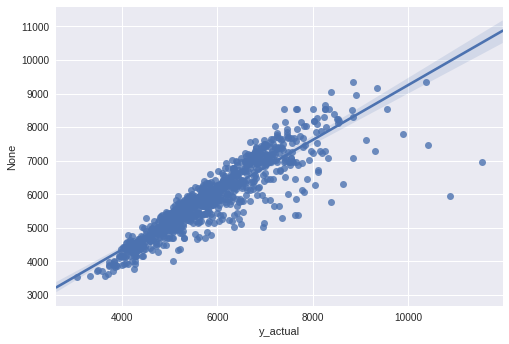

Lasso r^2:  0.812076004349


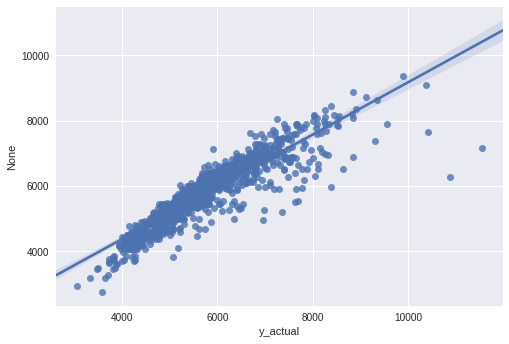

linear Regression r^2:  0.814369596847


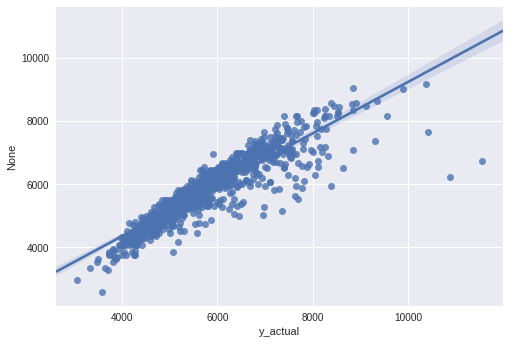

Ridge r^2:  0.808807649738


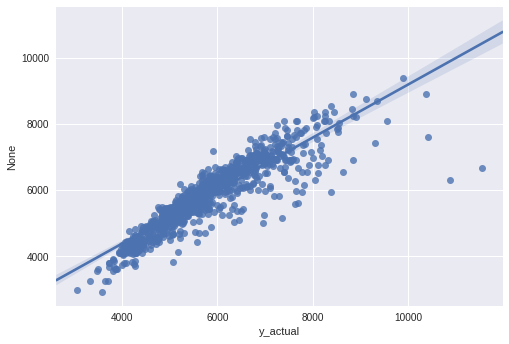

MLP r^2:  0.805905214021


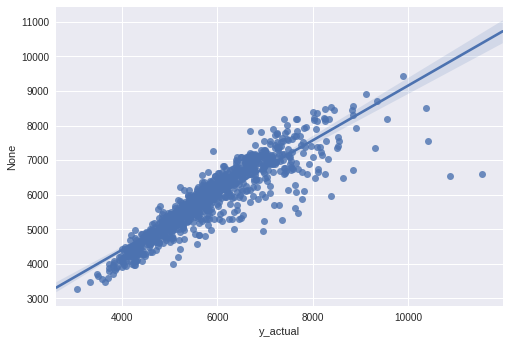

KernelRidge r^2:  0.809237953539


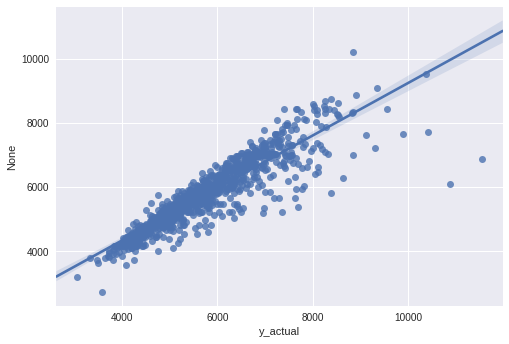

KNRegressor r^2:  0.746792889409


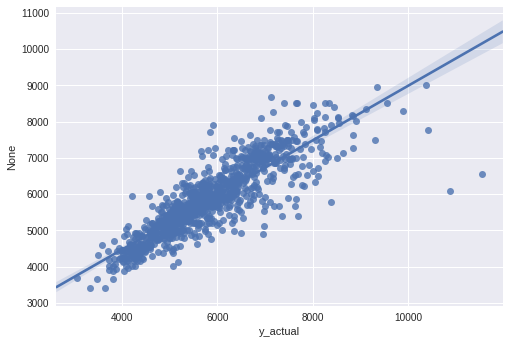

SVMRegressor r^2:  0.771597677342


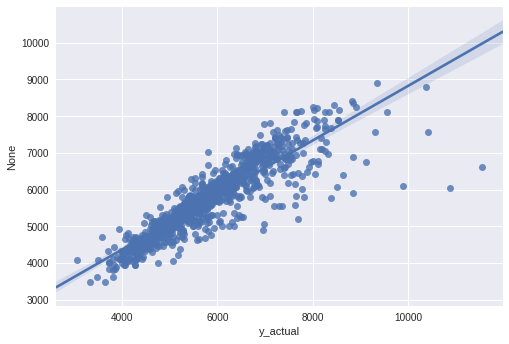

/home/kaggler/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/kaggler/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Tier 2 mean:  0.80905165292
mean:


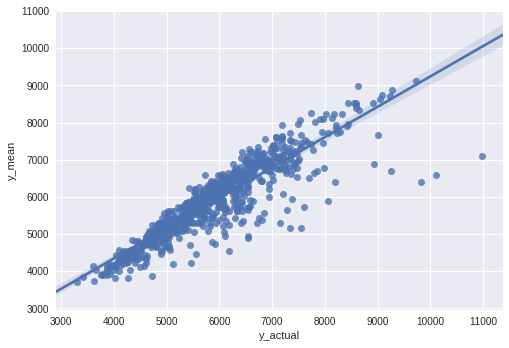

Tier 2 KNN:  0.775677826228


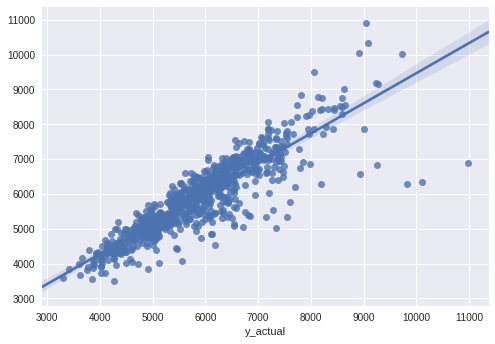

habe fertig....


In [42]:
list_test = ['X0', 'X1', 'X2', 'X5', 'X6', 'X8', 'qty_options']
list_index = ['X46', 'X189', 'X64', 'X29', 'X28', 'X20', 'X22', 'X171', 'X256', 'X158', 'X154', 'X150', 'X118', 'X337', 'X136', 'X111', 'X116', 'X115', 'X376', 'X50', 'X334', 'X79', 'X75', 'X264', 'X327', 'X166', 'X163', 'X148', 'X223', 'X224', 'X100', 'X103', 'X209', 'X202', 'X108', 'X378', 'X201', 'X314', 'X285', 'X336', 'X283', 'X129', 'X313', 'X127', 'X265', 'X120', 'X355', 'X261']
#list_index = ['X46', 'X189', 'X64', 'X29', 'X28', 'X20', 'X22', 'X171', 'X256', 'X158', 'X154', 'X150', 'X118', 'X337', 'X136', 'X111', 'X116', 'X115', 'X376', 'X334', 'X75', 'X264', 'X327', 'X166', 'X163', 'X148', 'X223', 'X224', 'X100', 'X103', 'X209', 'X202', 'X108', 'X201', 'X314', 'X285', 'X283', 'X129', 'X313', 'X127', 'X265', 'X120', 'X355', 'X261']
#list_index = ['X1', 'X4', 'X5', 'X6', 'X8', 'X46', 'X61', 'X64', 'X66', 'X28', 'X27', 'X20', 'X22', 'X171', 'X81', 'X256', 'X156', 'X150', 'X119', 'X294', 'X276', 'X130', 'X115', 'X129', 'X52', 'X76', 'X75', 'X283', 'X166', 'X163', 'X148', 'X374', 'X100', 'X103', 'X209', 'X321', 'X142', 'X147', 'X201', 'X316', 'X336', 'X337', 'X334', 'X313', 'X265', 'X261', 'X263']
#list_index = ['X46', 'X64', 'X29', 'X28', 'X20', 'X22', 'X171', 'X256', 'X158', 'X154', 'X150', 'X118', 'X136', 'X111', 'X116', 'X115', 'X129', 'X75', 'X127', 'X100', 'X163', 'X148', 'X224', 'X166', 'X103', 'X209', 'X283', 'X108', 'X314', 'X337', 'X334', 'X313', 'X264', 'X265', 'X261', 'X120']
#list_index = [e for e in list(df_train.columns.values) if e not in list_test + ['y', 'y_actual']]
#list_index = [e for e in list_index if e not in li_compliments + li_duplicates + ['y', 'y_actual']]
list_test = list_test + list_index
list_train = ['y_actual'] + list_test
list_test_2 = list_test + ['X1', 'X5', 'X6', 'X8']
list_train_2 = ['y_actual'] + list_test_2

df_X = df_train_eng[list_train_2].copy()
df_Kaggle = df_test_eng[list_test_2].copy()
df_y = df_X['y_actual']
df_X = df_X.drop('y_actual', axis=1)
result = pd.DataFrame()
frames = []

X2_train, X2_test, y2_train, y2_test = train_test_split(df_X, df_y, test_size=0.2, random_state=0)
result['qty_options'] = X2_test['qty_options']
result['y_actual'] = y2_test

model = RandomForestRegressor(n_estimators = 800, min_samples_leaf=6)
model, frames = compute_y(model, 'Random Forest', frames)

#model = ElasticNetCV(cv = 3, l1_ratio = [.001, .01, .1, .2, .6, .8], n_alphas = 170, selection = 'random', random_state = 999)
#model, frames = compute_y(model, 'Elastic Net', frames)

model = LassoCV(cv = 10, n_alphas = 200)
model, frames = compute_y(model, 'Lasso', frames)

model = LinearRegression()
model, frames = compute_y(model, 'linear Regression', frames)

model = RidgeCV(alphas=(25.0,), fit_intercept = True, cv = 7)
model, frames = compute_y(model, 'Ridge', frames)
#print model.coef_

model = MLPRegressor(hidden_layer_sizes=(140,140,140,140), max_iter = 300)
model, frames = compute_y(model, 'MLP', frames)

model = KernelRidge(alpha = 65.0, kernel='polynomial', degree = 3)
model, frames = compute_y(model, 'KernelRidge', frames)

model = KNeighborsRegressor(n_neighbors = 14, weights = 'distance', leaf_size = 3)
model, frames = compute_y(model, 'KNRegressor', frames)

#SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto', kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
#model = svm.SVR(C=1.0, cache_size=2000, degree = 3, epsilon=0.3, kernel='poly', verbose = True)
model = svm.SVR(C=1000.0, cache_size=2000, degree = 5, epsilon=0.00001, kernel='rbf', verbose = False)
model, frames = compute_y(model, 'SVMRegressor', frames)

result['y_mean'] = result[frames].mean(axis=1)
X2_train['y_mean'] = X2_train[frames].mean(axis=1)
X2_test['y_mean'] = result['y_mean']
df_Kaggle['y_mean'] = df_Kaggle[frames].mean(axis=1)
print 'Tier 2 mean: ', r2_score(result['y_actual'], result['y_mean'])

print 'mean:'
sns.regplot(result['y_actual'], result['y_mean'])
plt.show()

#model = LinearRegression()
#model = KNeighborsRegressor(n_neighbors = 40, weights = 'distance', leaf_size = 3)
#model = LassoCV(cv = 9, n_alphas = 50)
model = KernelRidge(alpha = 65.0, kernel='polynomial', degree = 3)
model.fit(X2_train[list_test_2], y2_train)
y_pred = model.predict(X2_test[list_test_2])
df_Kaggle['y_pred'] = model.predict(df_Kaggle[list_test_2])

print 'Tier 2 KNN: ', r2_score(y2_test, y_pred)
sns.regplot(y2_test, y_pred)
plt.show()

print 'habe fertig....'
#output_Kaggle = pd.Series(y_Kaggle['y_mean'] / y_Kaggle['qty_options'], name='y', index=y_Kaggle.index)
#output_Kaggle.to_csv(path='../data/201706131715.mean.csv', index_label='ID', header = True)

In [43]:
output_Kaggle = pd.Series(df_Kaggle['y_pred'] / df_Kaggle['qty_options'], name='y', index=df_Kaggle.index)
#output_Kaggle = pd.Series(df_Kaggle['KernelRidge'] / df_Kaggle['qty_options'], name='y', index=df_Kaggle.index)
#output = pd.concat([X2_test[list_test_2], pd.Series(y_pred, name='y_pred', index=y2_test.index), y2_test], axis=1) 
#output.to_csv(path_or_buf='../data/20170614.results.csv', index_label='ID', header = True)
output_Kaggle.to_csv(path='../data/201706141902.KernelRidge.csv', index_label='ID', header = True)

In [87]:
print y_pred

[  5483.77412639   5704.12885068   6021.41054287   5603.25779307
   8277.91274513   4424.4892996    5031.62369359   5549.60529193
   6928.90127983   7094.97980979   6871.81272961   5228.64883222
   5347.18709541   6696.17468921   6184.11627237   5825.687484
   4798.19487102   6083.78686569   7054.51052166   3877.7303424
   7107.63720961   5707.44683543   6583.57571356   5766.13452652
   7256.14429615   4237.10934685   5346.60389758   5337.76015252
   4532.00164796   6975.45226288   6541.32920541   5929.26925727
   4638.22269581   6133.30503977   6178.80198833   4239.91594158
   5658.80006516   5147.53438463   6707.62438643   5574.54290906
   4917.16797441   4245.31571316   5964.43083847   4106.42002337
   8085.52132002   5870.43038188   4223.83799648   6595.34327492
   5725.2475091    5746.06267903   4790.99863634   4425.51559729
   5576.02001416   4362.52708265   7258.4064853    5658.81018753
   5693.54322638   6498.8737181    4407.60909641   6635.36686256
   6116.03635908   6230.5957

In [44]:
df_train.head(5)


,y,X0,X1,X2,X3,X4,X5,X6,X8,X10,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,130.81,k,v,at,a,d,u,j,o,0,...,0,0,1,0,0,0,0,0,0,0
1,88.53,k,t,av,e,d,y,l,o,0,...,1,0,0,0,0,0,0,0,0,0
2,76.26,az,w,n,c,d,x,j,x,0,...,0,0,0,0,0,0,1,0,0,0
3,80.62,az,t,n,f,d,x,l,e,0,...,0,0,0,0,0,0,0,0,0,0
4,78.02,az,v,n,f,d,h,d,n,0,...,0,0,0,0,0,0,0,0,0,0


In [46]:
df_train_eng.head(5)

,y,X0,X1,X2,X3,X4,X5,X6,X8,X10,...,X377,X378,X379,X380,X382,X383,X384,X385,qty_options,y_actual
0,130.81,10,21,45,0,3,20,9,14,0,...,1,0,0,0,0,0,0,0,52,6802.12
1,88.53,10,19,47,4,3,24,11,14,0,...,0,0,0,0,0,0,0,0,52,4603.56
2,76.26,51,22,13,2,3,23,9,23,0,...,0,0,0,0,1,0,0,0,73,5566.98
3,80.62,51,19,13,5,3,23,11,4,0,...,0,0,0,0,0,0,0,0,62,4998.44
4,78.02,51,21,13,5,3,7,3,13,0,...,0,0,0,0,0,0,0,0,58,4525.16


In [49]:
for i in range(7):
    print 'X3 equals ', i, ' mean y:',
    print df_train_eng[(df_train_eng['X3'] == i)]['y'].mean(), ' y_actual:',
    print df_train_eng[(df_train_eng['X3'] == i)]['y_actual'].mean(), ' Datasets:',
    print df_train_eng[(df_train_eng['X3'] == i)].shape[0]

X3 equals  0  mean y: 102.507477273  y_actual: 6251.17375  Datasets: 440
X3 equals  1  mean y: 100.239649123  y_actual: 5609.35368421  Datasets: 57
X3 equals  2  mean y: 101.959268795  y_actual: 6117.26341401  Datasets: 1942
X3 equals  3  mean y: 105.114413793  y_actual: 5930.47831034  Datasets: 290
X3 equals  4  mean y: 100.033190184  y_actual: 5751.59521472  Datasets: 163
X3 equals  5  mean y: 96.4075255814  y_actual: 5209.7048186  Datasets: 1075
X3 equals  6  mean y: 100.428672199  y_actual: 5882.50087137  Datasets: 241


In [51]:
df_train_eng['y_actual'].mean()

5852.053060836502

In [56]:
df_train_eng.shape

(4208, 379)

In [54]:
df_train['X6'].describe()

count     4208
unique      12
top          g
freq      1042
Name: X6, dtype: object

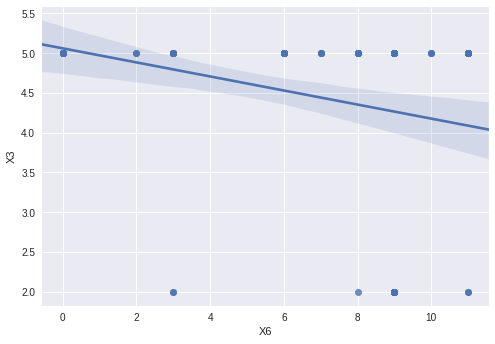

In [61]:
sns.regplot(df_train_eng[(df_train_eng['y'] < 80)]['X6'], df_train_eng[(df_train_eng['y'] < 80)]['X3'])
plt.show()